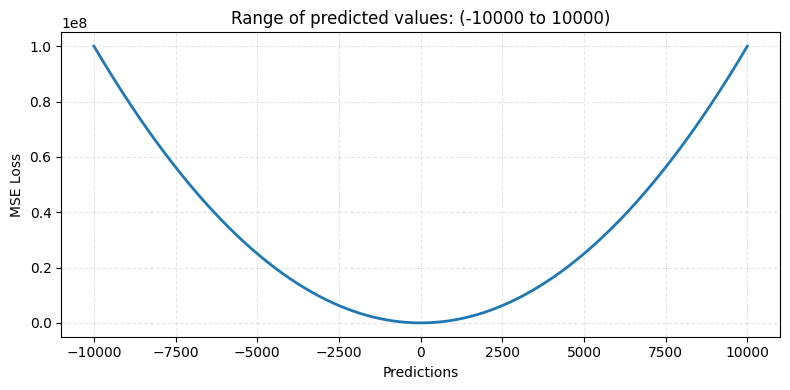

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetros del ejemplo
true_value = 0                         # Valor real
preds = np.linspace(-10_000, 10_000, 1000)  # Rango de predicciones
mse = (preds - true_value) ** 2             # Cálculo del MSE

# Gráfica
plt.figure(figsize=(8, 4))
plt.plot(preds, mse, linewidth=2)
plt.title(f"Range of predicted values: ({int(preds.min())} to {int(preds.max())})")
plt.xlabel("Predictions")
plt.ylabel("MSE Loss")
plt.grid(alpha=0.3, linestyle='--')  # opcional: malla tenue para que se parezca más
plt.tight_layout()

# Guardar en SVG
ruta_salida = r"C:\Users\joaqu\Downloads\mse_plot.svg"
plt.savefig(f"{ruta_salida}", format="svg", bbox_inches='tight')
plt.show()


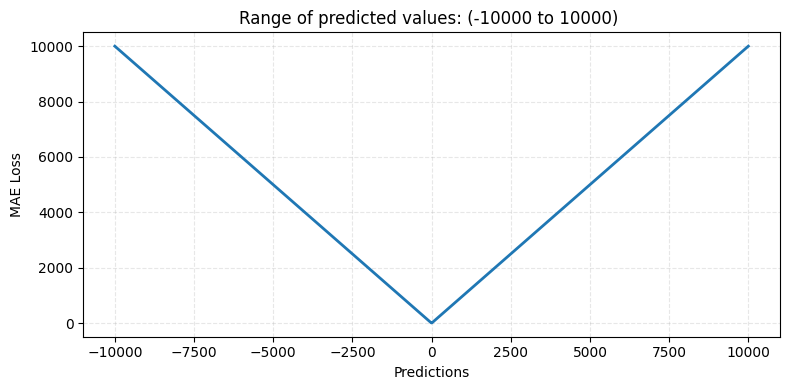

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Valor real 0 ⇒ el mínimo de MAE está en (0, 0)
true_value = 0
preds = np.linspace(-10_000, 10_000, 1000)   # Rango de predicciones
mae = np.abs(preds - true_value)             # Cálculo del MAE

plt.figure(figsize=(8, 4))
plt.plot(preds, mae, linewidth=2)
plt.title(f"Range of predicted values: ({int(preds.min())} to {int(preds.max())}) ")
plt.xlabel("Predictions")
plt.ylabel("MAE Loss")
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout()

# Guardar en SVG
ruta_salida = r"C:\Users\joaqu\Downloads\mae_plot.svg"
plt.savefig(f"{ruta_salida}", format="svg", bbox_inches='tight')
plt.show()


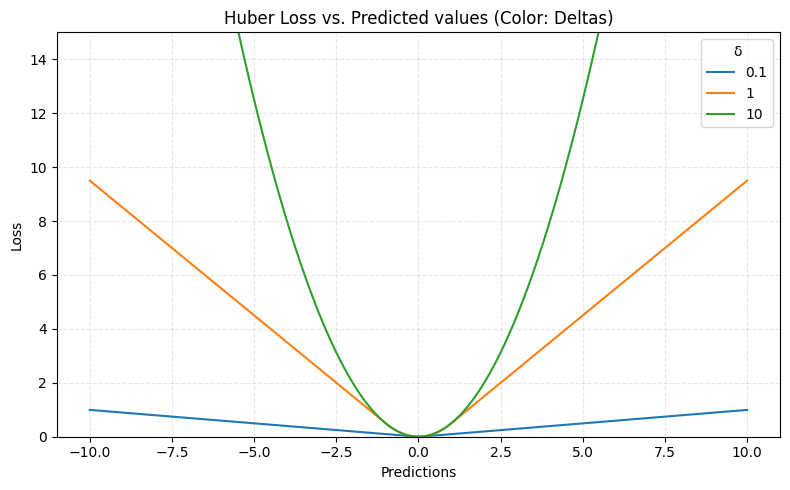

In [7]:
import numpy as np
import matplotlib.pyplot as plt

true_value = 0                      # Mínimo deseado en (0, 0)
preds = np.linspace(-10, 10, 1000)  # Rango de predicciones
error = preds - true_value

deltas = [0.1, 1, 10]               # Distintos δ de Huber

plt.figure(figsize=(8, 5))
for delta in deltas:
    huber = np.where(
        np.abs(error) <= delta,            # Parte cuadrática
        0.5 * error**2,
        delta * (np.abs(error) - 0.5*delta)  # Parte lineal
    )
    plt.plot(preds, huber, label=f"{delta}")

plt.title("Huber Loss vs. Predicted values (Color: Deltas)")
plt.xlabel("Predictions")
plt.ylabel("Loss")
plt.ylim(0, 15)
plt.legend(title="δ")
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout()

# Guardar en SVG
plt.savefig("huber_plot.svg", format="svg", bbox_inches='tight')
plt.show()

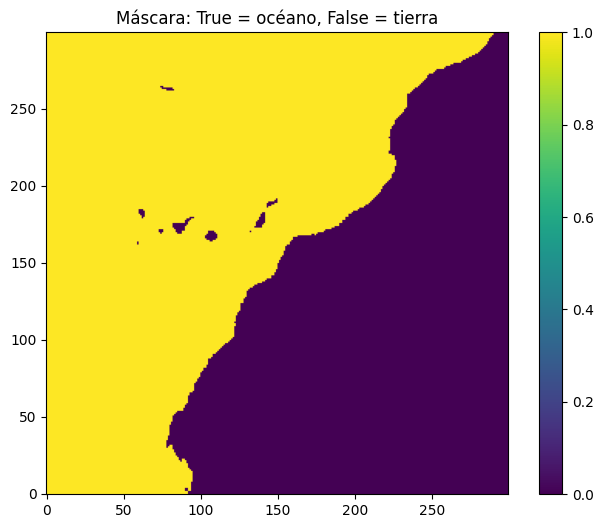

In [20]:
import numpy as np
import os
import matplotlib.pyplot as plt

BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
dir = os.path.join(BASE_DIR, "data", "atlantic", "static", "sea_mask.npy")

sea_mask = np.load(dir)

plt.figure(figsize=(8,6))
plt.title("Máscara: True = océano, False = tierra")
plt.imshow(sea_mask[0], origin="lower", cmap="viridis")
plt.colorbar()
sea_mask = sea_mask[0]  # Usar solo la primera capa si es 3D

ruta_salida = r"C:\Users\joaqu\Downloads\sea_mask.svg"
plt.savefig(f"{ruta_salida}", format="svg", bbox_inches='tight')
plt.show()


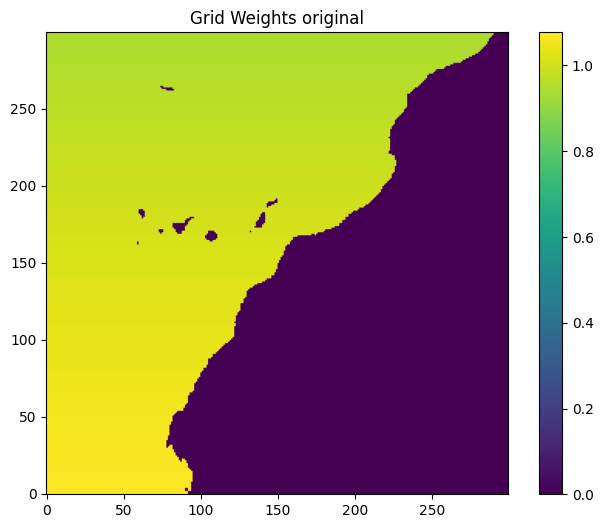

In [22]:
# Ruta de grid_weights
grid_weights_path = os.path.join(BASE_DIR, "data", "atlantic", "static", "grid_weights.npy")
grid_weights = np.load(grid_weights_path)  # Se espera una matriz de forma (H, W)

# Visualizamos la máscara original (opcional)
plt.figure(figsize=(8,6))
plt.imshow(grid_weights, origin="lower", cmap="viridis")
plt.title("Grid Weights original")
plt.colorbar()

ruta_salida = r"C:\Users\joaqu\Downloads\grid_weights.svg"
plt.savefig(f"{ruta_salida}", format="svg", bbox_inches='tight')
plt.show()

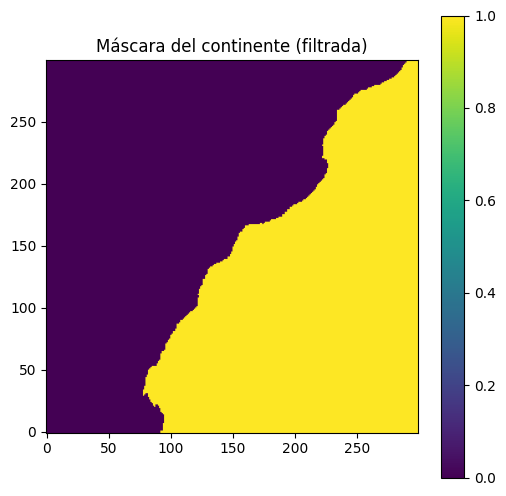

In [23]:
from skimage.measure import label, regionprops

# Convertir a boolean si no lo es
sea_mask = sea_mask.astype(bool)

# Calcular la máscara de tierra
land_mask = ~sea_mask

# Etiquetar componentes conectadas en la máscara de tierra
# Puedes experimentar con connectivity=1 o connectivity=2
land_labels = label(land_mask, connectivity=1)
regions = regionprops(land_labels)

# Filtrar regiones por área mínima (por ejemplo, descartar las islas pequeñas)
min_area = 500  # Ajusta este valor según la resolución y tamaño de las islas en tus datos
continent_mask = np.zeros_like(land_mask, dtype=bool)
for region in regions:
    if region.area >= min_area:
        # Agregamos esta región al continente
        continent_mask |= (land_labels == region.label)

# Cargar las coordenadas (asumiendo que la primera capa corresponde a las latitudes)
coords_path = os.path.join(BASE_DIR, "data", "atlantic", "static", "coordinates.npy")
coords = np.load(coords_path)  # (2, H, W)
lat = coords[0]  # (H, W)
lon = coords[1]  # (H, W)

# Visualizar la máscara del continente filtrado (opcional)
plt.figure(figsize=(6,6))
plt.imshow(continent_mask, origin="lower", cmap="viridis")
plt.title("Máscara del continente (filtrada)")
plt.colorbar()
plt.show()

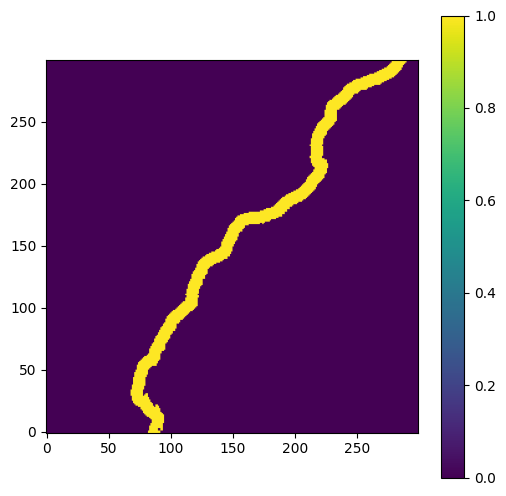

In [25]:
from scipy.ndimage import distance_transform_edt
# Calcular la distancia desde cada celda (de mar) al continente filtrado.
# Invertimos continent_mask, ya que queremos medir distancia a la tierra
distance_to_continent = distance_transform_edt(~continent_mask)

# Crear la máscara de banda costera: celdas de mar cuya distancia al continente es <= 10 celdas.
banda_costera_continente = (distance_to_continent <= 10) & sea_mask

plt.figure(figsize=(6,6))
plt.imshow(banda_costera_continente, origin="lower", cmap="viridis")
plt.colorbar()

ruta_salida = r"C:\Users\joaqu\Downloads\banda_costera.svg"
plt.savefig(f"{ruta_salida}", format="svg", bbox_inches='tight')
plt.show()

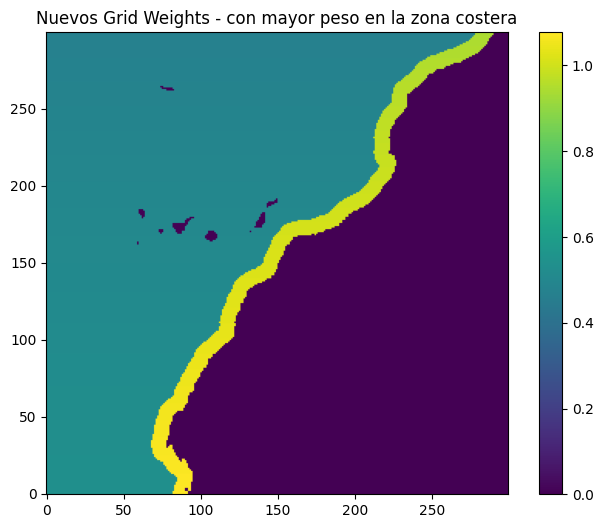

In [27]:
# Definir un factor para aumentar la importancia de la banda costera
factor = 2.0  # Puedes ajustar este factor a lo que consideres adecuado

# Hacer una copia de los grid_weights para modificarla
new_grid_weights = grid_weights.copy()

# Aumentar los pesos en las celdas de la banda costera
new_grid_weights[banda_costera_continente] *= factor

# Asegurarse de que las celdas de tierra tengan peso 0
new_grid_weights[~sea_mask] = 0
new_grid_weights *= 0.5  # Reducir el peso fuera de la banda costera

# Visualizar la nueva máscara de pesos
plt.figure(figsize=(8,6))
plt.imshow(new_grid_weights, origin="lower", cmap="viridis")
plt.title("Nuevos Grid Weights - con mayor peso en la zona costera")
plt.colorbar()

ruta_salida = r"C:\Users\joaqu\Downloads\grid_weights_upwelling1.svg"
plt.savefig(f"{ruta_salida}", format="svg", bbox_inches='tight')
plt.show()

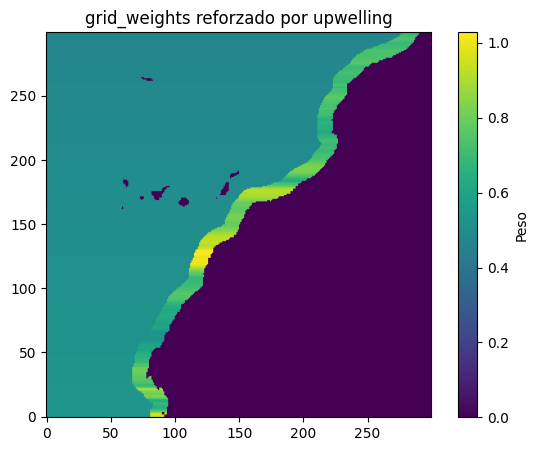

In [29]:
# ------------------------------------------------------------
# Coastal-Upwelling-Aware grid_weights for the Atlantic domain
# ------------------------------------------------------------
import os, numpy as np, xarray as xr, matplotlib.pyplot as plt
from scipy.ndimage import distance_transform_edt          # SciPy
from skimage.measure import label, regionprops

# --- 1. Rutas ------------------------------------------------
BASE_DIR   = os.path.abspath(os.path.join(os.getcwd(), ".."))
STATIC_DIR = os.path.join(BASE_DIR, "data", "atlantic", "static")

SEA_MASK_F   = os.path.join(STATIC_DIR, "sea_mask.npy")          # (1,H,W)
COORD_F      = os.path.join(STATIC_DIR, "coordinates.npy")       # (2,H,W)
GRID_W_F     = os.path.join(STATIC_DIR, "grid_weights.npy")
CLIMA_SST_F  = os.path.join(STATIC_DIR, "climatology_dayofyear.nc")
OUT_F        = os.path.join(STATIC_DIR, "grid_weights_upwelling.npy")

# --- 2. Datos base -------------------------------------------
sea_mask = np.load(SEA_MASK_F)[0].astype(bool)           # H×W
lat, lon = np.load(COORD_F)                              # H×W
grid_weights = np.load(GRID_W_F)                         # H×W

ds = xr.open_dataset(CLIMA_SST_F).squeeze()              # climatología diaria
if "analysed_sst" in ds:                                 # armoniza nombre
    ds = ds.rename(analysed_sst="sst_temperature")
if "time" in ds.dims and "dayofyear" not in ds.dims:     # ★ aquí el cambio
    ds = ds.rename({"time": "dayofyear"})
sst = ds["sst_temperature"].isel(dayofyear=0)            # (lat,lon)
sst_arr = sst.values

# --- 3. Construir máscara continental robusta ---------------
land = ~sea_mask
labels = label(land, connectivity=1)
continent = np.zeros_like(land, bool)
min_area = 500                                            # píxeles²
for reg in regionprops(labels):
    if reg.area >= min_area:
        continent |= labels == reg.label

# --- 4. Distancia a costa y franja ≤ 3.5° --------------------
# resoluciones: |Δlon| ≈ 1 º/px    (válido si tu grid es regular)
deg_per_px = np.abs(np.diff(lon, axis=1)).mean()
dist_px  = distance_transform_edt(~continent)
dist_deg = dist_px * deg_per_px
coastal_band = (dist_deg <= 0.6) & sea_mask

# --- 5. CUI por latitud --------------------------------------
CUI = np.zeros(lat.shape[0])
for j in range(lat.shape[0]):
    band = coastal_band[j]
    if band.any():
        col = sst_arr[j, band]
        CUI[j] = col.max() - col.min()                    # ΔSST

CUI_norm = (CUI - CUI.min()) / (CUI.ptp() or 1)
factor_lat  = 1.0 + CUI_norm                              # 1-2
factor_grid = np.broadcast_to(factor_lat[:, None], sea_mask.shape)

# --- 6. Aplicar factor de upwelling --------------------------
upwelling_factor = np.where(coastal_band, factor_grid, 1.0)
new_grid_weights = grid_weights * upwelling_factor
new_grid_weights[~sea_mask] = 0
new_grid_weights *= 0.5

# --- 7. Guardar y visualizar ---------------------------------

plt.figure(figsize=(7,5))
plt.imshow(new_grid_weights, origin="lower", cmap="viridis")
plt.title("grid_weights reforzado por upwelling")
plt.colorbar(label="Peso")
ruta_salida = r"C:\Users\joaqu\Downloads\grid_weights_upwelling_casi_high.svg"
plt.savefig(f"{ruta_salida}", format="svg", bbox_inches='tight')

plt.show()


Nuevo grid_weights con upwelling guardado en: c:\Users\joaqu\Documents\seacast-prueba5\Seacast\data\atlantic\static\grid_weights_upwelling.npy


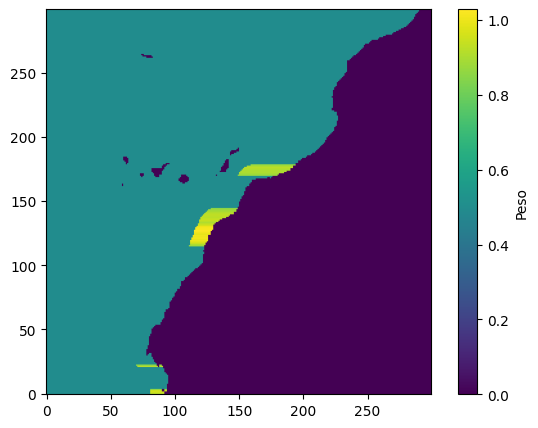

In [31]:
# ------------------------------------------------------------
# Coastal-Upwelling-Aware grid_weights for the Atlantic domain
# ------------------------------------------------------------
import os, numpy as np, xarray as xr, matplotlib.pyplot as plt
from scipy.ndimage import distance_transform_edt
from skimage.measure import label, regionprops

# --- 1. Rutas -------------------------------------------------
BASE_DIR   = os.path.abspath(os.path.join(os.getcwd(), ".."))
STATIC_DIR = os.path.join(BASE_DIR, "data", "atlantic", "static")

SEA_MASK_F   = os.path.join(STATIC_DIR, "sea_mask.npy")
COORD_F      = os.path.join(STATIC_DIR, "coordinates.npy")
GRID_W_F     = os.path.join(STATIC_DIR, "grid_weights.npy")
CLIMA_SST_F  = os.path.join(STATIC_DIR, "climatology_dayofyear.nc")
OUT_F        = os.path.join(STATIC_DIR, "grid_weights_upwelling.npy")

# --- 2. Datos base -------------------------------------------
sea_mask = np.load(SEA_MASK_F)[0].astype(bool)
lat, lon = np.load(COORD_F)
grid_weights = np.load(GRID_W_F)

ds = xr.open_dataset(CLIMA_SST_F).squeeze()
if "analysed_sst" in ds:
    ds = ds.rename(analysed_sst="sst_temperature")
if "time" in ds.dims and "dayofyear" not in ds.dims:
    ds = ds.rename({"time": "dayofyear"})
sst_arr = ds["sst_temperature"].isel(dayofyear=0).values

# --- 3. Máscara continental robusta --------------------------
land = ~sea_mask
labels = label(land, connectivity=1)
continent = np.zeros_like(land, bool)
for reg in regionprops(labels):
    if reg.area >= 500:                       # píxeles²
        continent |= labels == reg.label

# --- 4. Distancia a costa y franja ≤ 0.6 ° --------------------
deg_per_px = np.abs(np.diff(lon, axis=1)).mean()
dist_deg   = distance_transform_edt(~continent) * deg_per_px
coastal_band = (dist_deg <= 0.6) & sea_mask

# --- 5. CUI por latitud --------------------------------------
CUI = np.zeros(lat.shape[0])
for j in range(lat.shape[0]):
    band = coastal_band[j]
    if band.any():
        slice_ = sst_arr[j, band]
        CUI[j] = slice_.max() - slice_.min()

factor_lat  = 1.0 + (CUI - CUI.min()) / (CUI.ptp() or 1)   # 1-2
factor_grid = np.broadcast_to(factor_lat[:, None], sea_mask.shape)

# --- 6. Aplicar factor y filtro solicitado -------------------
up_factor          = np.where(coastal_band, factor_grid, 1.0)
new_grid_weights   = grid_weights * up_factor
new_grid_weights[~sea_mask] = 0
new_grid_weights  *= 0.5                                   # atenuación global

# ► Filtro: valores en (0.5, 0.8) → 0.5
mask_05_08 = (new_grid_weights > 0.4) & (new_grid_weights < 0.85)
new_grid_weights[mask_05_08] = 0.5

# --- 7. Guardar y visualizar ---------------------------------
print("Nuevo grid_weights con upwelling guardado en:", OUT_F)

plt.figure(figsize=(7,5))
plt.imshow(new_grid_weights, origin="lower", cmap="viridis")
plt.colorbar(label="Peso")

ruta_salida = r"C:\Users\joaqu\Downloads\grid_weights_upwelling.svg"
plt.savefig(f"{ruta_salida}", format="svg", bbox_inches='tight')
plt.show()


Directorio raíz fijado en: c:\Users\joaqu\Documents\seacast-prueba5\Seacast
=== Percentiles |error| ===
P50: 0.3413
P80: 0.5986
P90: 0.8332
P95: 1.0666
P98: 1.3957
P99: 1.8352

>>> δ recomendado (P80): 0.5986


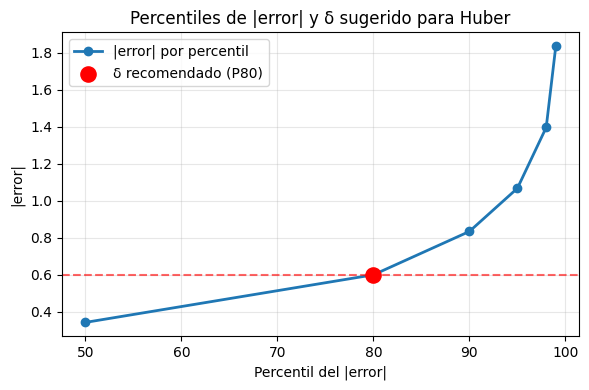

c:\Users\joaqu\miniconda3\envs\tfg2\lib\site-packages\dask\core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
c:\Users\joaqu\miniconda3\envs\tfg2\lib\site-packages\dask\core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
c:\Users\joaqu\miniconda3\envs\tfg2\lib\site-packages\dask\core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
c:\Users\joaqu\miniconda3\envs\tfg2\lib\site-packages\dask\core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
c:\Users\joaqu\miniconda3\envs\tfg2\lib\site-packages\dask\core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
c:\Users\joaqu\miniconda3\envs\tfg2\lib\site-packages\dask\core.py:127: RuntimeWarning: invalid valu

In [ ]:
# %% ========================== Huber δ auto-tuning (val/test) ==========================
import dask.array as da
import numpy as np, os, re
if "_SRC_PATH_SET_" not in globals():
    globals()["_SRC_PATH_SET_"] = True
    src_path = os.path.abspath(os.path.join(os.getcwd(), '..'))
    os.chdir(src_path)
    print(f"Directorio raíz fijado en: {src_path}")
else:
    from pathlib import Path
    print(f"Ruta ya establecida, sigo en: {Path.cwd()}")
import os, numpy as np, dask.array as da, xarray as xr
import torch

# -------------------- CONFIG --------------------
VAR       = "sst_temperature"
DATASET   = "atlantic"
STATIC    = f"data/atlantic/static"
TARGET_DIR = f"data/atlantic/samples/test"
PRED_DIR   = r"E:\seacast-prueba5\Seacast\wandb\run-20250709_103556-7q6tinze\files\predictions"

EXTRA_VARS   = ["coordinates", "mask"]
EXTRA_FILES  = [os.path.join(STATIC, "coordinates.npy"),
                os.path.join(STATIC, "sea_mask.npy")]

LIMIT_LEADS  = None
YEAR_SLICE   = None

PCTS = [50, 75, 90, 95, 98, 99]
DEFAULT_PICK = 90

MAX_SAMPLE = 5_000_000

# -------------------- Load preds/targets --------------------
from src.seacast_tools.np_loaders import TargetsFromNumpy, PredictionsFromNumpy
targets = TargetsFromNumpy(
    path=TARGET_DIR,
    variables=[VAR],
    extra_variables=EXTRA_VARS,
    extra_files=EXTRA_FILES,
).load_chunk()

preds = PredictionsFromNumpy(
    path=PRED_DIR,
    variables=[VAR],
    extra_variables=EXTRA_VARS,
    extra_files=EXTRA_FILES,
).load_chunk()

def normalize(ds):
    ds = ds.transpose(*(d for d in ("init_time","lead_time","latitude","longitude") if d in ds.dims))
    return ds.chunk({d: min(ds.sizes.get(d,1), n) for d,n in
                     {"init_time":32,"lead_time":16,"latitude":100,"longitude":100}.items() if d in ds.dims})

targets, preds = map(normalize, (targets, preds))

# Alinear tiempos
common_inits = np.intersect1d(targets.init_time.values, preds.init_time.values)
targets = targets.sel(init_time=common_inits)
preds   = preds  .sel(init_time=common_inits)

if YEAR_SLICE:
    targets = targets.sel(init_time=slice(*YEAR_SLICE))
    preds   = preds.sel(init_time=slice(*YEAR_SLICE))
if LIMIT_LEADS:
    targets = targets.isel(lead_time=slice(0, LIMIT_LEADS))
    preds   = preds  .isel(lead_time=slice(0, LIMIT_LEADS))

# -------------------- Construir errores absolutos --------------------
err_abs = da.fabs(preds[VAR].data - targets[VAR].data)   # dask array
mask    = da.isfinite(err_abs)
vals    = da.ravel(err_abs[mask])                        # 1D lazy

# Asegura tamaños de chunk conocidos
vals = vals.compute_chunk_sizes()

# Tamaño real (número de valores finitos)
n_vals = int(da.count_nonzero(mask).compute())

# Muestreo opcional para no cargar demasiados puntos en memoria
MAX_SAMPLE = 5_000_000
if n_vals > MAX_SAMPLE:
    stride = max(1, n_vals // MAX_SAMPLE)
    vals_sampled = vals[::stride]
else:
    vals_sampled = vals

# Percentiles directamente en Dask (no hace falta traer todo)
PCTS = [50, 80, 90, 95, 98, 99]
pct_vals = da.percentile(vals_sampled, PCTS).compute()

print("=== Percentiles |error| ===")
for p, v in zip(PCTS, pct_vals):
    print(f"P{p:02d}: {v:.4f}")

DEFAULT_PICK = 80
delta_rec = float(pct_vals[PCTS.index(DEFAULT_PICK)])
print(f"\n>>> δ recomendado (P{DEFAULT_PICK}): {delta_rec:.4f}")

# %% ---------- Gráfica percentiles |error| y δ recomendado ----------
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 4))

# Línea principal
ax.plot(PCTS, pct_vals, marker="o", lw=2, label="|error| por percentil")

# Punto y línea horizontal del δ elegido
ax.scatter([DEFAULT_PICK], [delta_rec],
           color="red", s=120, zorder=5,
           label=f"δ recomendado (P{DEFAULT_PICK})")
ax.axhline(delta_rec, color="red", ls="--", alpha=0.6)

ax.set_xlabel("Percentil del |error|")
ax.set_ylabel("|error|")
ax.set_title("Percentiles de |error| y δ sugerido para Huber")
ax.grid(alpha=0.3)
ax.legend()

plt.tight_layout()

ruta_salida = r"C:\Users\joaqu\Downloads\lambda_huber.svg"
plt.savefig(f"{ruta_salida}", format="svg", bbox_inches='tight')
plt.show()


Ruta ya establecida, sigo en: c:\Users\joaqu\Documents\seacast-prueba5\Seacast


c:\Users\joaqu\miniconda3\envs\tfg2\lib\site-packages\dask\utils.py:460: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explicitly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  return self.fn(key)
c:\Users\joaqu\miniconda3\envs\tfg2\lib\site-packages\dask\utils.py:460: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(


=== MÉTRICAS GLOBALES ponderadas ===
RMSE: 0.436   MAE: 0.297   Bias: -0.160   ACC: 0.846   PACT: 0.829

=== MÉTRICAS EN BANDA COSTERA (upwelling) ===
RMSE_banda: 0.5981   MAE_banda: 0.4123   Bias_banda: -0.0660   ACC_b: 0.673   PACT_b: 0.769
→ GIF guardado en rmse_animation_run-20250709_103556-7q6tinze_files.gif

=== PONDERADO por lead_time (global) ===
Lead 01:  RMSE=0.0683  MAE=0.0473  Bias=-0.0100  ACC=0.973  PACT=0.979
Lead 02:  RMSE=0.1334  MAE=0.0951  Bias=-0.0264  ACC=0.945  PACT=0.964
Lead 03:  RMSE=0.1960  MAE=0.1414  Bias=-0.0467  ACC=0.919  PACT=0.945
Lead 04:  RMSE=0.2525  MAE=0.1836  Bias=-0.0690  ACC=0.896  PACT=0.923
Lead 05:  RMSE=0.3044  MAE=0.2226  Bias=-0.0923  ACC=0.876  PACT=0.899
Lead 06:  RMSE=0.3512  MAE=0.2578  Bias=-0.1159  ACC=0.859  PACT=0.875
Lead 07:  RMSE=0.3939  MAE=0.2900  Bias=-0.1394  ACC=0.844  PACT=0.851
Lead 08:  RMSE=0.4326  MAE=0.3194  Bias=-0.1626  ACC=0.831  PACT=0.827
Lead 09:  RMSE=0.4684  MAE=0.3468  Bias=-0.1854  ACC=0.820  PACT=0.803
Lea

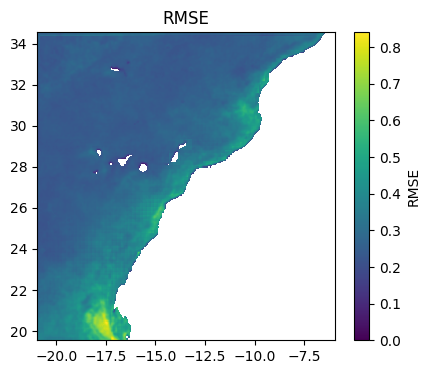

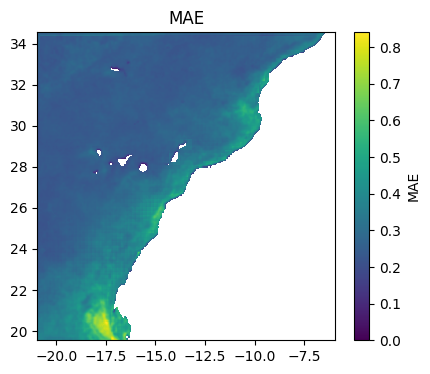

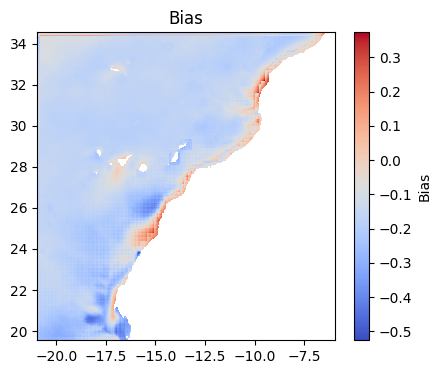

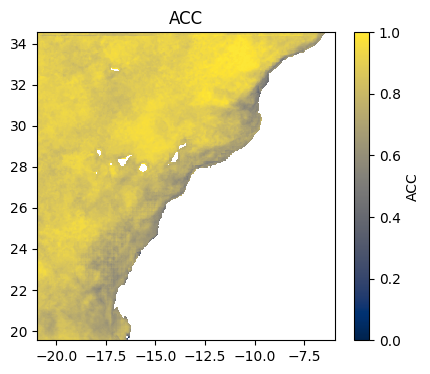

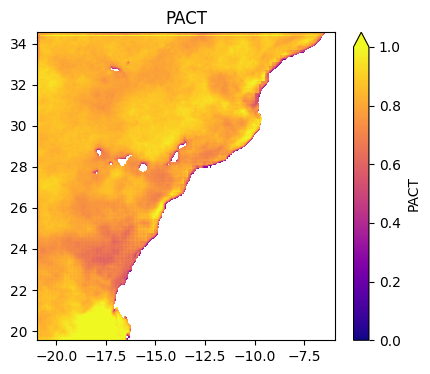

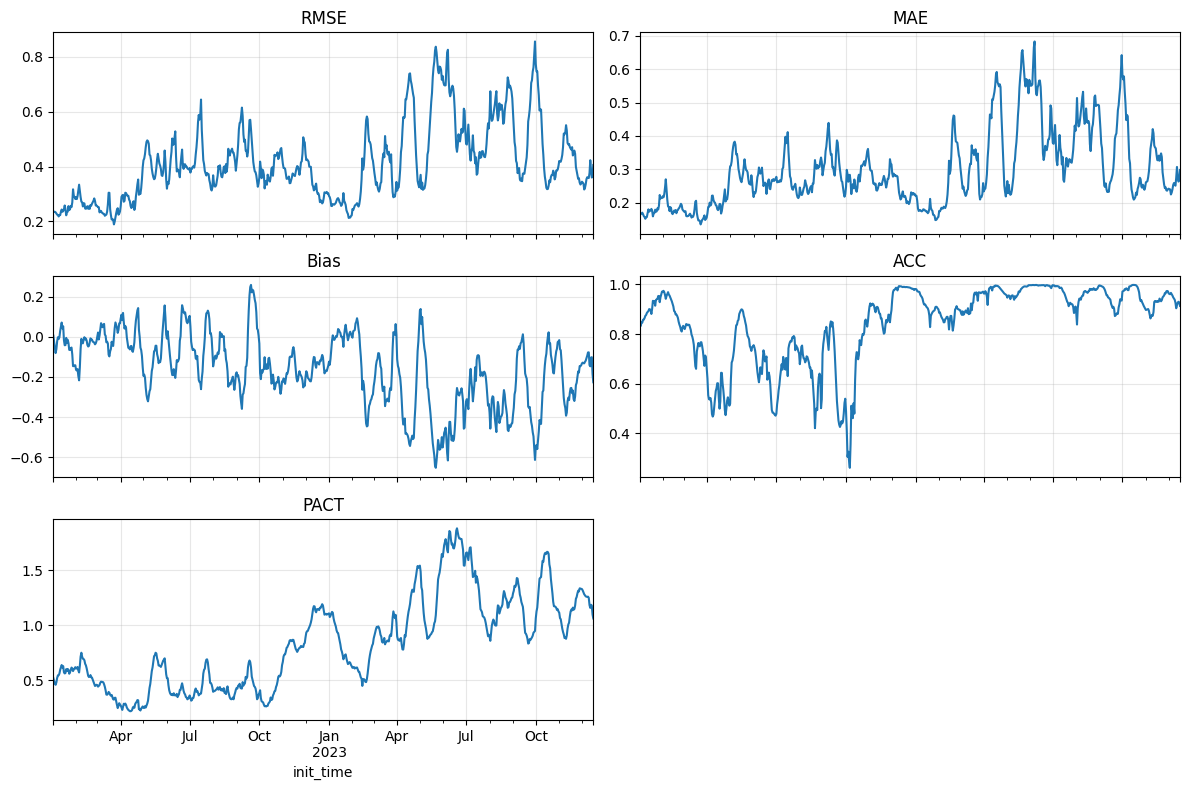

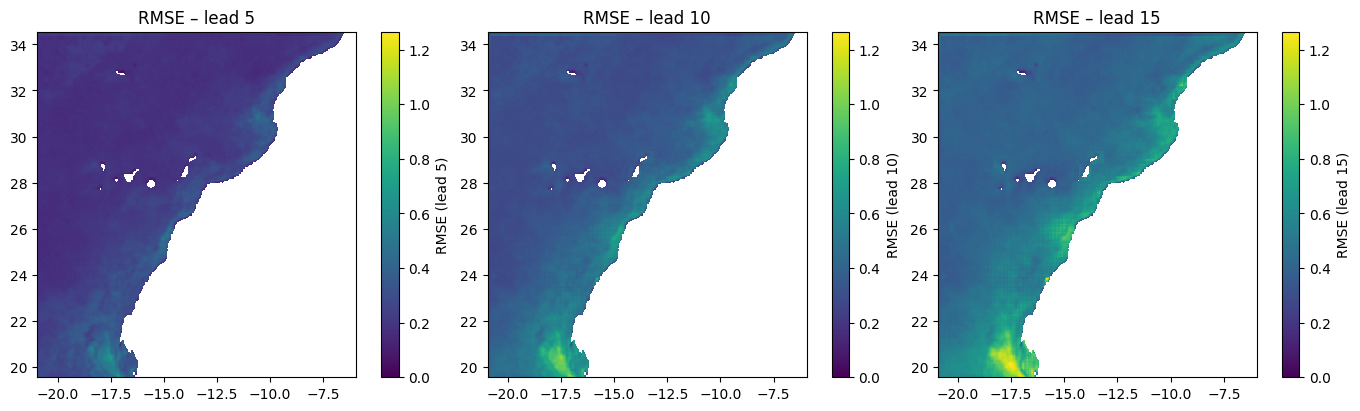

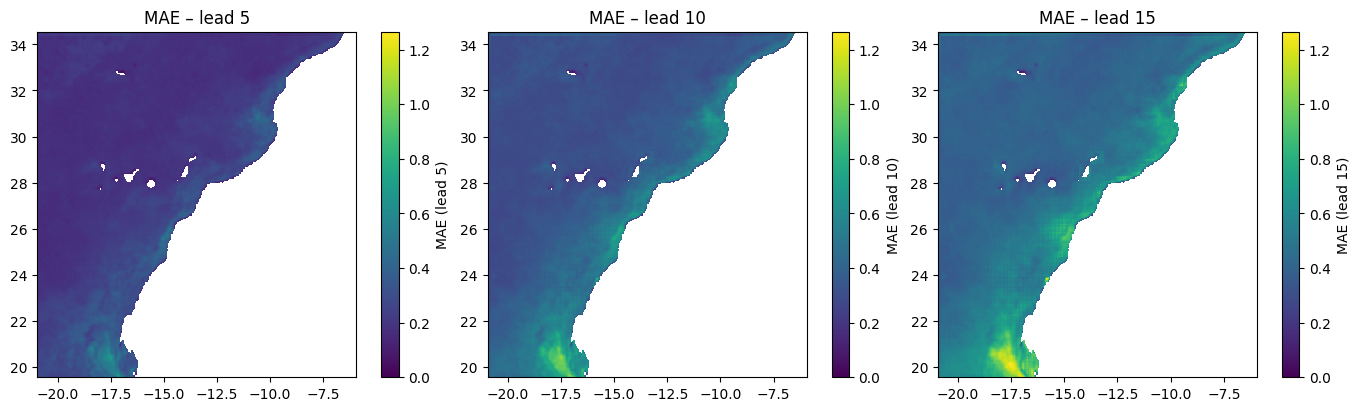

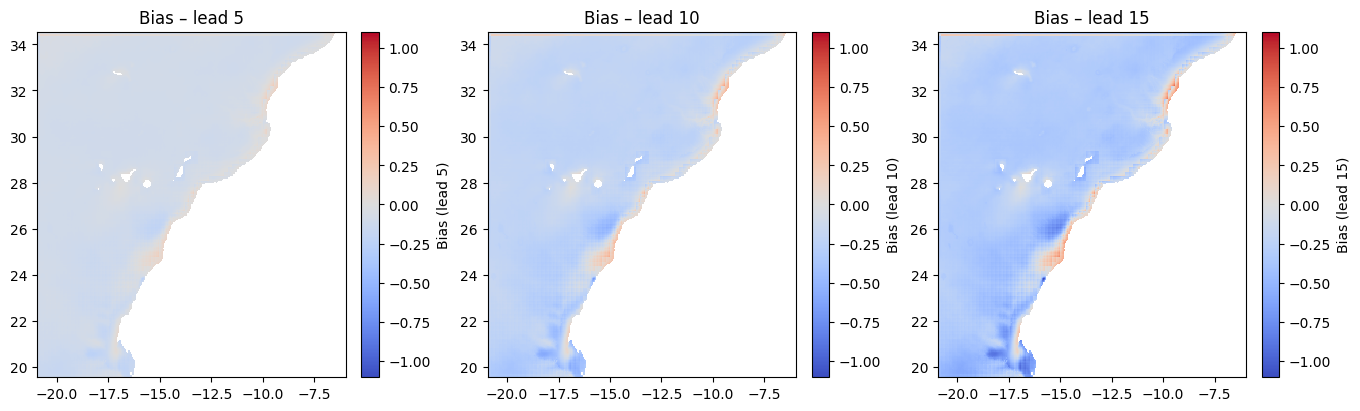

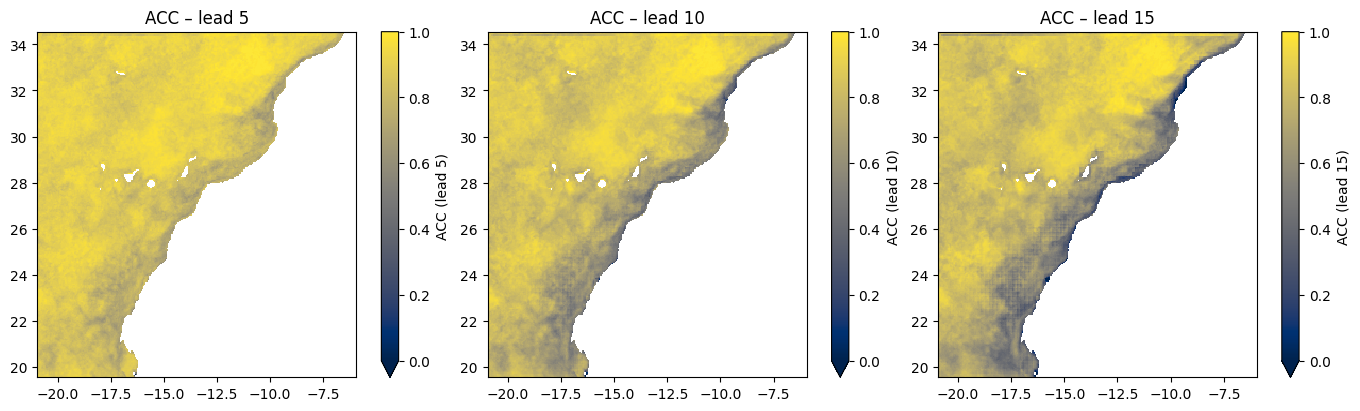

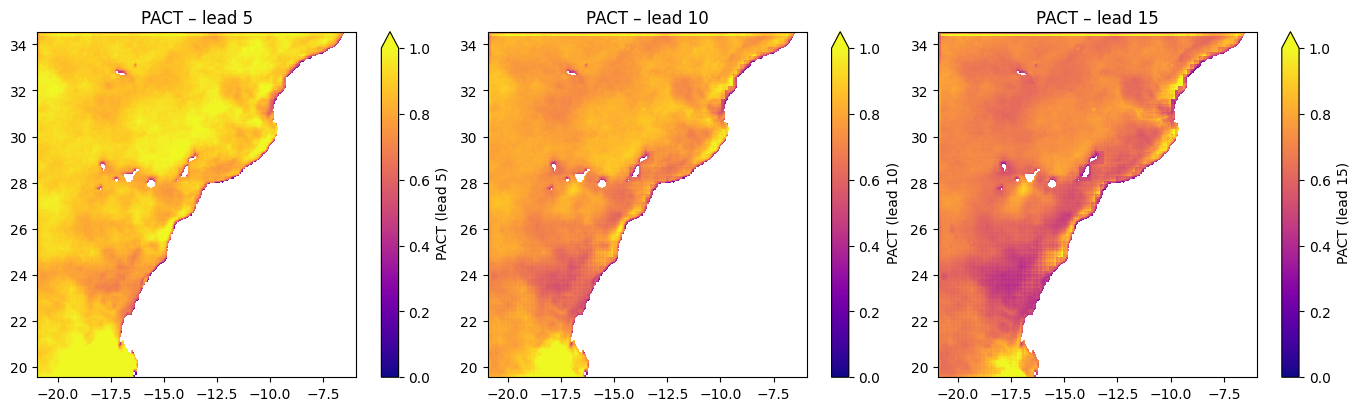

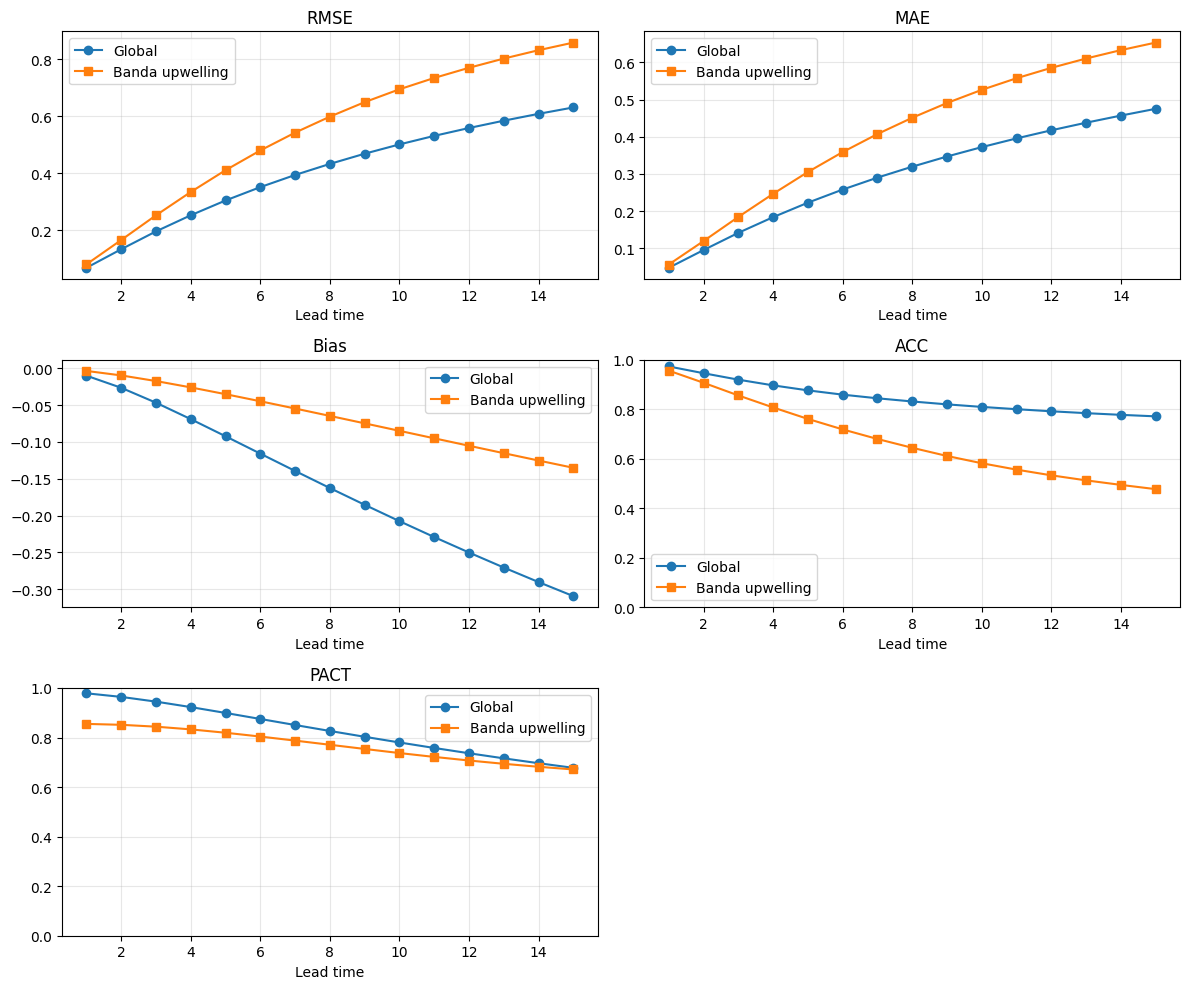

In [34]:
import dask.array as da
import numpy as np, os, re
if "_SRC_PATH_SET_" not in globals():
    globals()["_SRC_PATH_SET_"] = True
    src_path = os.path.abspath(os.path.join(os.getcwd(), '..'))
    os.chdir(src_path)
    print(f"Directorio raíz fijado en: {src_path}")
else:
    from pathlib import Path
    print(f"Ruta ya establecida, sigo en: {Path.cwd()}")
    
# %% ------------------------------------ IMPORTS & PATHS ------------------------------------
import os, numpy as np, dask.array as da, xarray as xr, dask
from weatherbenchX.metrics import deterministic as det
from weatherbenchX.metrics import base as wx_base
import matplotlib.pyplot as plt


# %% ----------------------------------- DATA ------------------------------------------
VAR       = "sst_temperature"
DATASET   = "atlantic"
STATIC    = f"data/{DATASET}/static"
STATIC_DIR    = f"data/{DATASET}/static"
TARGET_DIR = f"data/{DATASET}/samples/test"
PRED_DIR   = r"E:\seacast-prueba5\Seacast\wandb\run-20250709_103556-7q6tinze\files\predictions"

EXTRA_VARS   = ["coordinates", "mask"]
EXTRA_FILES  = [
    os.path.join(STATIC_DIR, "coordinates.npy"),
    os.path.join(STATIC_DIR, "sea_mask.npy")
]

GRID_WEIGHTS_FILE = os.path.join(STATIC, "grid_weights.npy")           
NORMALIZE_WEIGHTS = False                                              
LIMIT_LEADS, YEAR_SLICE = None, None                                   

# %% ------------------------------------ LOAD PRED & TARGET ---------------------------------
from src.seacast_tools.np_loaders import TargetsFromNumpy, PredictionsFromNumpy
targets = TargetsFromNumpy(
    path=TARGET_DIR,
    variables=[VAR],
    extra_variables=EXTRA_VARS,
    extra_files=EXTRA_FILES,
).load_chunk()

preds = PredictionsFromNumpy(
    path=PRED_DIR,
    variables=[VAR],
    extra_variables=EXTRA_VARS,
    extra_files=EXTRA_FILES,
).load_chunk()

def normalize(ds):
    ds = ds.transpose(*(d for d in ("init_time","lead_time","latitude","longitude") if d in ds.dims))
    return ds.chunk({d: min(ds.sizes.get(d,1), n) for d, n in
                     {"init_time":32, "lead_time":16, "latitude":100, "longitude":100}.items() if d in ds.dims})

targets, preds = map(normalize, (targets, preds))

common_inits = np.intersect1d(targets.init_time, preds.init_time)
targets, preds = (ds.sel(init_time=common_inits) for ds in (targets, preds))
if YEAR_SLICE: 
    targets = targets.sel(init_time=slice(*YEAR_SLICE))
    preds   = preds.sel(init_time=slice(*YEAR_SLICE))
if LIMIT_LEADS:
    targets = targets.isel(lead_time=slice(0, LIMIT_LEADS))
    preds   = preds  .isel(lead_time=slice(0, LIMIT_LEADS))

# %% ------------------------------------ CLIMATOLOGY p/ACC‑PACT -----------------------------
clim = (xr.open_dataset(os.path.join(STATIC,"climatology_dayofyear.nc"),
                        chunks={"dayofyear":366,"latitude":100,"longitude":100})
          .rename_vars(analysed_sst=VAR))
if "dayofyear" in clim.dims:                      
    n_doy = clim.sizes["dayofyear"]

elif "time" in clim.dims:                         
    clim = clim.rename({"time": "dayofyear"})
    n_doy = clim.sizes["dayofyear"]

else:                                             
    n_doy = 366
    clim = clim.expand_dims({"dayofyear": n_doy})

if "dayofyear" not in clim.coords:
    clim = clim.assign_coords(dayofyear=np.arange(1, n_doy + 1))

# %% ------------------------------------ WBX metric‑maps (for plots) ------------------------
metrics_wbx = {"rmse":det.RMSE(),"mae":det.MAE(),"bias":det.Bias(),
               "acc":det.ACC(climatology=clim),"pact":det.PredictionActivity(climatology=clim)}
stats   = wx_base.compute_unique_statistics_for_all_metrics(metrics_wbx, {VAR:preds[VAR]}, {VAR:targets[VAR]})
result  = wx_base.compute_metrics_from_statistics(metrics_wbx, stats)   # maps (init,lat,lon)

# %% ------------------------------------ GRID WEIGHTS + upwelling mask ----------------------
# weights
grid_w = np.load(GRID_WEIGHTS_FILE); grid_w = grid_w[0] if grid_w.ndim==3 else grid_w
if NORMALIZE_WEIGHTS: grid_w /= grid_w.sum()
grid_w_da = xr.DataArray(grid_w, coords={"latitude":targets.latitude,"longitude":targets.longitude},
                         dims=("latitude","longitude"))

# upwelling band mask ----
upw_band_bool = np.load(os.path.join(STATIC, "upwelling_band.npy")).astype(bool)
if upw_band_bool.shape != (targets.latitude.size, targets.longitude.size):
    raise ValueError(
        f"upwelling_band.npy tiene shape {upw_band_bool.shape} y se esperaba "
        f"({targets.latitude.size}, {targets.longitude.size})"
    )

upw_band_da = xr.DataArray(upw_band_bool, coords=grid_w_da.coords, dims=grid_w_da.dims)

# %% ------------------------------------ WEIGHTED GLOBAL METRICS -----------------------
pred_da, targ_da = preds[VAR], targets[VAR]
err  = pred_da - targ_da; abs_e, sq_e = np.abs(err), err**2

def w_mean_da(da, w):
    mask = np.isfinite(da)
    w_eff = w.where(mask, 0)
    return (da*w_eff).sum(dim=("latitude","longitude")) / w_eff.sum(dim=("latitude","longitude"))

rmse_w = ( (sq_e*grid_w_da).sum(dim=("latitude","longitude")) / (grid_w_da.where(np.isfinite(err)).sum(dim=("latitude","longitude"))) ).mean().pipe(np.sqrt).compute()
mae_w  = w_mean_da(abs_e, grid_w_da).mean().compute()
bias_w = w_mean_da(err   , grid_w_da).mean().compute()
acc_w  = w_mean_da(result["acc"][VAR],  grid_w_da).mean().compute()
pact_w = w_mean_da(result["pact"][VAR], grid_w_da).mean().compute()

print("\n=== MÉTRICAS GLOBALES ponderadas ===")
print(f"RMSE: {rmse_w:.3f}   MAE: {mae_w:.3f}   Bias: {bias_w:+.3f}   ACC: {acc_w:.3f}   PACT: {pact_w:.3f}")

# Weighted Per‑lead (RMSE/MAE) -----------------
num_mse_lead = (sq_e*grid_w_da).sum(dim=("init_time","latitude","longitude"))
num_mae_lead = (abs_e*grid_w_da).sum(dim=("init_time","latitude","longitude"))
den_lead     = grid_w_da.where(np.isfinite(err)).sum(dim=("init_time","latitude","longitude"))
rmse_per_lead = np.sqrt((num_mse_lead/den_lead).compute())
mae_per_lead  = (num_mae_lead/den_lead).compute()

# %% ------------------------------------ UPWELLING BAND METRICS ------------------------
w_band = grid_w_da.where(upw_band_da, 0)
rmse_up = w_mean_da(sq_e, w_band).mean().pipe(np.sqrt).compute()
mae_up  = w_mean_da(abs_e, w_band).mean().compute()
bias_up = w_mean_da(err  , w_band).mean().compute()
acc_up  = w_mean_da(result["acc"][VAR],  w_band).mean().compute()
pact_up = w_mean_da(result["pact"][VAR], w_band).mean().compute()

print("\n=== MÉTRICAS EN BANDA COSTERA (upwelling) ===")
print(f"RMSE_banda: {rmse_up:.4f}   MAE_banda: {mae_up:.4f}   Bias_banda: {bias_up:+.4f}   ACC_b: {acc_up:.3f}   PACT_b: {pact_up:.3f}")


# %% ------------------------------------ GIF RMSE (lead_time) --------------------------

import imageio.v2 as iio, tempfile, shutil, pathlib

lead_idx = 14          
rmse_da = result["rmse"][VAR].isel(lead_time=lead_idx)  # dims: init_time, lat, lon

gif_tmp = tempfile.mkdtemp()
for k, t in enumerate(rmse_da.init_time):
    fig, ax = plt.subplots(figsize=(4.5, 3.5))
    rmse_da.sel(init_time=t).plot.imshow(
        ax=ax, vmin=0, vmax=1, cmap="viridis",
        cbar_kwargs={"label": f"RMSE (lead {lead_idx+1})"}
    )
    ax.set_title(np.datetime_as_string(t.values, unit="D"))
    ax.axis("off")
    fname = os.path.join(gif_tmp, f"{k:03d}.png")
    fig.savefig(fname, dpi=120, bbox_inches="tight")
    plt.close(fig)

gif_name = f"rmse_animation_{pathlib.Path(PRED_DIR).parts[-3]}_{pathlib.Path(PRED_DIR).parts[-2]}.gif"
frames = [iio.imread(os.path.join(gif_tmp, f)) for f in sorted(os.listdir(gif_tmp))]
iio.mimsave(gif_name, frames, duration=0.6, loop=0)
shutil.rmtree(gif_tmp)
print("→ GIF guardado en", gif_name)

# ════════════════════════════════════════════════════════════════════════════
# METRICS WEIGHTED BY lead_time ➜ global & upwelling band
# ════════════════════════════════════════════════════════════════════════════
def w_mean_lead(da, w):
    """
    Media ponderada (lat,lon,init) para cada lead_time.
    da : DataArray (..., lead, lat, lon)
    w  : DataArray (lat,lon)  — sin NaN, 0 donde no pese
    """
    # Denominator: sum of weights where the data is finite
    w_eff = w.where(np.isfinite(da), 0)
    den   = w_eff.sum(dim=("init_time","latitude","longitude"))
    num   = (da * w_eff).sum(dim=("init_time","latitude","longitude"))
    return num / den

# --- Global (all weights) ---
rmse_lead   = np.sqrt( w_mean_lead(sq_e,  grid_w_da) )
mae_lead    =        w_mean_lead(abs_e,  grid_w_da)
bias_lead   =        w_mean_lead(err  ,  grid_w_da)
acc_lead    =        w_mean_lead(result["acc"][VAR] , grid_w_da)
pact_lead   =        w_mean_lead(result["pact"][VAR], grid_w_da)

print("\n=== PONDERADO por lead_time (global) ===")
for i in range(rmse_lead.sizes["lead_time"]):
    print(f"Lead {i+1:02d}:  "
          f"RMSE={float(rmse_lead[i]):.4f}  "
          f"MAE={float(mae_lead[i]):.4f}  "
          f"Bias={float(bias_lead[i]):+.4f}  "
          f"ACC={float(acc_lead[i]):.3f}  "
          f"PACT={float(pact_lead[i]):.3f}")

# --- Upwelling band only ---
rmse_lead_up = np.sqrt( w_mean_lead(sq_e , w_band) )
mae_lead_up  =        w_mean_lead(abs_e , w_band)
bias_lead_up =        w_mean_lead(err   , w_band)
acc_lead_up  =        w_mean_lead(result["acc"][VAR] , w_band)
pact_lead_up =        w_mean_lead(result["pact"][VAR], w_band)

print("\n=== PONDERADO por lead_time (banda up‑welling) ===")
for i in range(rmse_lead_up.sizes["lead_time"]):
    print(f"Lead {i+1:02d}:  "
          f"RMSE_b={float(rmse_lead_up[i]):.4f}  "
          f"MAE_b={float(mae_lead_up[i]):.4f}  "
          f"Bias_b={float(bias_lead_up[i]):+.4f}  "
          f"ACC_b={float(acc_lead_up[i]):.3f}  "
          f"PACT_b={float(pact_lead_up[i]):.3f}")

# %% ------------------------------------ MEAN MAPS ----------------------------
import matplotlib.pyplot as plt
def collapse_for_maps(da):
    for dim in ("lead_time","init_time"):
        if dim in da.dims: da = da.mean(dim)
    return da

bias_mean = collapse_for_maps(result["bias"][VAR])
rmse_mean = collapse_for_maps(result["rmse"][VAR])
mae_mean  = collapse_for_maps(result["mae" ][VAR])
acc_mean  = collapse_for_maps(result["acc" ][VAR])
pact_mean = collapse_for_maps(result["pact"][VAR])

def plot_metric(da,title,vmin,vmax,cmap):
    ax = da.plot.imshow(cmap=cmap,vmin=vmin,vmax=vmax,
                        figsize=(4.8,4),cbar_kwargs={"label":title})
    ax.axes.set_title(title); ax.axes.set_xlabel(""); ax.axes.set_ylabel("")
    ruta_salida = f"C:\\Users\\joaqu\\Downloads\\metric_{title.lower()}.svg"
    plt.savefig(ruta_salida, format="svg", bbox_inches='tight')
    plt.show()

plot_metric(rmse_mean,"RMSE",0,float(rmse_mean.max()),"viridis")
plot_metric(mae_mean ,"MAE" ,0,float(mae_mean .max()),"viridis")
plot_metric(bias_mean,"Bias",float(bias_mean.min()),float(bias_mean.max()),"coolwarm")
plot_metric(acc_mean ,"ACC" ,0,1,"cividis")
plot_metric(pact_mean,"PACT",0,1,"plasma")

# %% ---------------------------- TIME-SERIES  -------------------------
import pandas as pd
import matplotlib.pyplot as plt

# --‑ aggregates (lat, lon) with weights --
w_latlon = grid_w_da                       
mask_ok  = np.isfinite(err)                

def mean_spatial_weighted(da):
    """Weighted average (lat,lon) keeping dim init_time (and lead_time if it exists)."""
    w_eff = w_latlon.where(mask_ok, 0)
    return (da * w_eff).sum(("latitude","longitude")) / w_eff.sum(("latitude","longitude"))

# RMSE – first spatially weighted mean of the MSE and then √
rmse_ts = np.sqrt( mean_spatial_weighted(err**2)
                   .mean(dim="lead_time")            
                   .compute()                        
                   .to_series() )

mae_ts  = ( mean_spatial_weighted(np.abs(err))
            .mean(dim="lead_time")
            .compute()
            .to_series() )

bias_ts = ( mean_spatial_weighted(err)
            .mean(dim="lead_time")
            .compute()
            .to_series() )

acc_ts  = ( mean_spatial_weighted(result["acc"][VAR])
            .mean(dim="lead_time")
            .compute()
            .to_series() )

pact_ts = ( mean_spatial_weighted(result["pact"][VAR])
            .mean(dim="lead_time")
            .compute()
            .to_series() )

# --- DataFrame & plot ----------------------------------------------------
df_ts = pd.DataFrame({
    "rmse": rmse_ts,
    "mae" : mae_ts,
    "bias": bias_ts,
    "acc" : acc_ts,
    "pact": pact_ts,
})

fig, axes = plt.subplots(3, 2, figsize=(12, 8), sharex=True); axes = axes.ravel()
for ax, col, title in zip(
        axes,
        ["rmse","mae","bias","acc","pact"],
        ["RMSE","MAE","Bias","ACC","PACT"]):
    df_ts[col].plot(ax=ax)
    ax.set_title(title); ax.grid(alpha=.3)

axes[-1].set_visible(False)
plt.tight_layout()
ruta_salida = r"C:\Users\joaqu\Downloads\metric_timeseries.svg"
plt.savefig(ruta_salida, format="svg", bbox_inches='tight')
plt.show()

# %% ---------------------------- MAPAS PER LEAD (5, 10 and 15) ------------------------------
import matplotlib.pyplot as plt

leads_to_plot = [5, 10, 15]          
lead_indices  = [l-1 for l in leads_to_plot]

rmse_leads  = [result["rmse"][VAR].isel(lead_time=i).mean("init_time") for i in lead_indices]
mae_leads   = [result["mae" ][VAR].isel(lead_time=i).mean("init_time") for i in lead_indices]
bias_leads  = [result["bias"][VAR].isel(lead_time=i).mean("init_time") for i in lead_indices]
acc_leads   = [result["acc" ][VAR].isel(lead_time=i).mean("init_time") for i in lead_indices]
pact_leads  = [result["pact"][VAR].isel(lead_time=i).mean("init_time") for i in lead_indices]

# Common limits (so that scales are comparable between leads)
rmse_vmax = max(float(da.max()) for da in rmse_leads)
mae_vmax  = max(float(da.max()) for da in mae_leads)
bias_abs  = max(float(abs(da).max()) for da in bias_leads)

def plot_lead_maps(das, title_base, cmap, vmin, vmax):
    """Plots a list of DataArrays (one per lead) in a row."""
    n = len(das)
    fig, axes = plt.subplots(1, n, figsize=(4.5*n, 4), constrained_layout=True)
    if n == 1:
        axes = [axes]
    for ax, da, lead in zip(axes, das, leads_to_plot):
        da.plot.imshow(ax=ax, cmap=cmap, vmin=vmin, vmax=vmax,
                       cbar_kwargs={"label": f"{title_base} (lead {lead})"})
        ax.set_title(f"{title_base} – lead {lead}")
        ax.set_xlabel(""); ax.set_ylabel("")
    ruta_salida = f"C:\\Users\\joaqu\\Downloads\\{title_base.lower()}_leads.svg"
    plt.savefig(ruta_salida, format="svg", bbox_inches='tight')
    plt.show()

# Plot
plot_lead_maps(rmse_leads, "RMSE", "viridis", 0, rmse_vmax)
plot_lead_maps(mae_leads , "MAE" , "viridis", 0, mae_vmax)
plot_lead_maps(bias_leads, "Bias", "coolwarm", -bias_abs, bias_abs)
plot_lead_maps(acc_leads , "ACC" , "cividis", 0, 1)
plot_lead_maps(pact_leads, "PACT", "plasma" , 0, 1)

# ==== METRIC CURVES vs LEAD TIME (global vs band upwelling) ====
import matplotlib.pyplot as plt

# Vector of lead times (1..N)
lead_axis = np.arange(1, rmse_lead.sizes["lead_time"] + 1)

# We move on to NumPy arrays
rmse_g  = rmse_lead.values
mae_g   = mae_lead.values
bias_g  = bias_lead.values
acc_g   = acc_lead.values
pact_g  = pact_lead.values

rmse_b  = rmse_lead_up.values
mae_b   = mae_lead_up.values
bias_b  = bias_lead_up.values
acc_b   = acc_lead_up.values
pact_b  = pact_lead_up.values

fig, axes = plt.subplots(3, 2, figsize=(12, 10))
axes = axes.ravel()

def plot_metric_curve(ax, y_global, y_band, title, ylabel=None, ylim=None):
    ax.plot(lead_axis, y_global, marker="o", label="Global")
    ax.plot(lead_axis, y_band,   marker="s", label="Banda upwelling")
    ax.set_title(title)
    ax.set_xlabel("Lead time")
    if ylabel: ax.set_ylabel(ylabel)
    if ylim: ax.set_ylim(*ylim)
    ax.grid(alpha=.3)
    ax.legend()

plot_metric_curve(axes[0], rmse_g, rmse_b, "RMSE")
plot_metric_curve(axes[1], mae_g,  mae_b,  "MAE")
plot_metric_curve(axes[2], bias_g, bias_b, "Bias")
plot_metric_curve(axes[3], acc_g,  acc_b,  "ACC",  ylim=(0,1))
plot_metric_curve(axes[4], pact_g, pact_b, "PACT", ylim=(0,1))

axes[5].axis("off")
plt.tight_layout()

ruta_salida = r"C:\Users\joaqu\Downloads\metric_curves_lead.svg"
plt.savefig(ruta_salida, format="svg", bbox_inches='tight')
plt.show()